# FaceID verification using One-shot learning method

## Importing Libraries

In [8]:
#importing dependencies
import cv2
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#import tensorflow functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam


## Loading and Preprocessing the data

### Creating folders and Setting up the paths

In [13]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

#making directories

os.makedirs(POS_PATH, exist_ok = True)
os.makedirs(NEG_PATH, exist_ok = True)
os.makedirs(ANC_PATH, exist_ok = True)

### Untaring the labelled images

In [14]:
# Run the following to decrypt the data file.
#!tar -xf lfw.tgz

In [4]:
# Moving the LFW Images to the repository data/negative
for directory in os.listdir('lfw'):
    # Check if 'directory' is a directory (not a file or other type)
    if os.path.isdir(os.path.join('lfw', directory)):
        for file in os.listdir(os.path.join('lfw', directory)):
            # Check if the file starts with a dot (e.g., ".DS_Store") and skip it
            if file.startswith('.'):
                continue

            EX_PATH = os.path.join('lfw', directory, file)
            NEW_PATH = os.path.join(NEG_PATH, file)
            os.replace(EX_PATH, NEW_PATH)


### Collecting images

In [1]:
#To generate unique image names importing uuid library
import uuid

In [6]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    res, frame = cap.read()
    
    # Cut down frame to 250x200px
    frame = cv2.resize(frame,(250,200))
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):## To collect the anchor images press the key "a"
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):## To collect the positive images press the key "p"
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #show image
    cv2.imshow('Image_Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'): ## To stop press "q"
        break
        
cap.release()
cv2.destroyAllWindows()

### Data augmentation

In [8]:
# Augmentation function to augment the input images which provides more data to the model
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6,upper= 1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed = (np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90,max_jpeg_quality=100, seed = (np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1,seed = (np.random.randint(100),np.random.randint(100)))

        data.append(img)
    return data


In [9]:
# Input images augmentation
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    
    if img is not None:
        aug_imgs = data_aug(img)

        for image in aug_imgs:
            cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# True images augmentation
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)

    if img is not None:
        aug_imgs = data_aug(img)

        for image in aug_imgs:
            cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

### Getting the directories

In [15]:
anchor_fileset = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(2000)
positive_fileset= tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(2000)
negative_fileset = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(2000)

In [21]:
#Preprocessing data
def preprocess(file_path):
    image = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(image)
    img = tf.image.resize(img, (100,100))
    img = img/255
    return img

### Creating dataset

In [16]:
positives = tf.data.Dataset.zip((anchor_fileset, positive_fileset, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_fileset)))))
negatives = tf.data.Dataset.zip((anchor_fileset, negative_fileset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor_fileset)))))
dataset = positives.concatenate(negatives)

In [18]:
def preprocess_data(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
# Build dataloader pipeline
dataset = dataset.map(preprocess_data)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=8000)

In [23]:
# Training partition
train_data = dataset.take(round(len(dataset)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = dataset.skip(round(len(dataset)*.7))
test_data = test_data.take(round(len(dataset)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model Building

### Custom model

In [6]:
# Creating our custom model to customise the training step

class CustomModel(Model):
    def train_step(self,batch):
        #unpacking the data
        x = batch[:2] #x data
        y = batch[2] #label
        
        with tf.GradientTape() as tape:
            y_pred = self(x, training = True) #Forward Pass
            #loss compilation
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

        
        

### Embedding layer

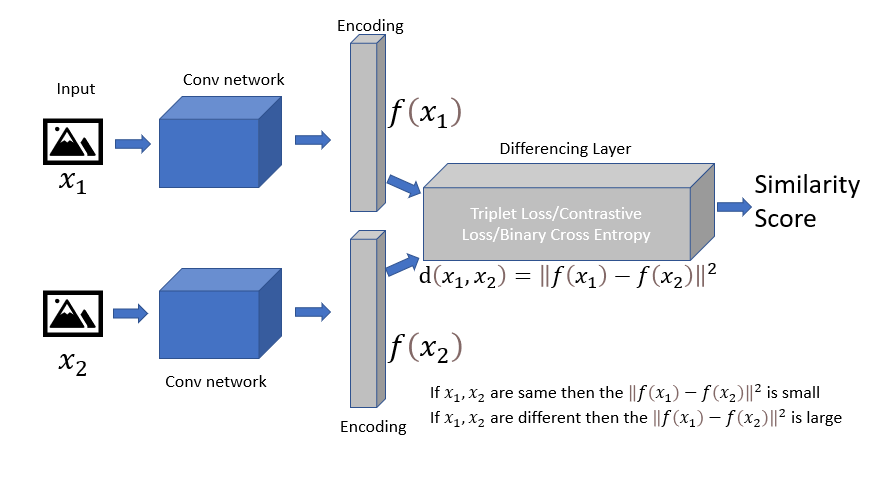

The following architecture is implemented based on the paper "siamese neural networks for one-shot image recognition" proposed on One-shot learning in 2015.  

In [7]:
#function to build embedding layer

def build_embedding():
    feed = Input(name = 'input_image', shape = (100,100,3))
    
    #first part
    c1 = Conv2D(64,(10,10), activation = 'relu')(feed)
    m1 = MaxPooling2D(64,(2,2), padding='same')(c1)
    
    #second part
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding='same')(c2)
    
    #third part
    c3 = Conv2D(128,(4,4), activation = 'relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding = 'same')(c3)
    
    #Fourth part
    c4 = Conv2D(256,(4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    return CustomModel(inputs = [feed], outputs = [d1], name = 'embedding')

### Distance Layer

In [21]:
#Distance layer to calculate the distance between the input image and the validation(anchor) image.
# Siamese L1 Distance class
class DistanceLayer(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### Siamese model
Building a Siamese network architecture to validate the input image against the anchor image.

In [22]:

def build_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    embedding = build_embedding()
    # Combine siamese distance components
    siamese_layer = DistanceLayer()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return CustomModel(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [23]:
siamese_model = build_siamese_model()

### Training the model

In [26]:
binary_loss = binary_crossentropy #loss function
opt = Adam(1e-4) #Adam optimizer and setting the learning rate to 0.0001

#compiling the model
siamese_model.compile(loss = binary_loss, optimizer = opt, metrics = ['accuracy'])

In [28]:
#training the model against the dataset that was created earlier
history = siamese_model.fit(train_data, epochs = 100) 

Epoch 1/100
17/17 [==============================] - 64s 4s/step - loss: 0.1562 - accuracy: 0.9361
Epoch 2/100
17/17 [==============================] - 70s 4s/step - loss: 0.1170 - accuracy: 0.9511
Epoch 3/100
17/17 [==============================] - 68s 4s/step - loss: 0.1309 - accuracy: 0.9737
Epoch 4/100
17/17 [==============================] - 65s 4s/step - loss: 0.0682 - accuracy: 0.9850
Epoch 5/100
17/17 [==============================] - 68s 4s/step - loss: 0.0321 - accuracy: 0.9962
Epoch 6/100
17/17 [==============================] - 72s 4s/step - loss: 0.0233 - accuracy: 0.9962
Epoch 7/100
17/17 [==============================] - 81s 5s/step - loss: 0.0263 - accuracy: 0.9887
Epoch 8/100
17/17 [==============================] - 71s 4s/step - loss: 0.1492 - accuracy: 0.9624
Epoch 9/100
17/17 [==============================] - 68s 4s/step - loss: 0.0431 - accuracy: 0.9850
Epoch 10/100
17/17 [==============================] - 66s 4s/step - loss: 0.0082 - accuracy: 1.0000
Epoch 11/

### Saving the model

In [26]:
siamese_model.save('Final_FACEID_model')

### Loading the model

In [27]:
FaceID_model = tf.keras.models.load_model('Final_FACEID_model') #loading the saved model

In [11]:
FaceID_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

### Making predictions

In [28]:
#Getting a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [29]:

y_hat = FaceID_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[2.4199609e-14],
       [1.0000000e+00],
       [2.4738477e-12],
       [3.2380480e-11],
       [1.0000000e+00],
       [2.5705593e-09],
       [2.8948835e-14],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.3288196e-10],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.6348866e-11],
       [1.8798930e-06],
       [1.0000000e+00]], dtype=float32)

In [30]:
# Post processing the results 
y_pred = [1 if prediction > 0.5 else 0 for prediction in y_hat ]
y_pred

[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]

In [31]:
y_true

array([0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1.],
      dtype=float32)

It is observed that the model makes the predictions with high accuracy. Let's further evaluate with different metrics.

### Calculating metrics

In [33]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



To test it in real-time create folder called "Application data".
Further within this create two more folders "input_images" and "verification_images".

### Testing in Real-time

### Verification funciton

In [34]:
def verify_image(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold 
    print(verification)
    
    return results, verified

In [38]:

cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame = cv2.resize(frame,(250,200))
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify_image(FaceID_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
'''

cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame = cv2.resize(frame,(250,200))
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

'''

"\n\ncap = cv2.VideoCapture(1)\nwhile cap.isOpened():\n    ret, frame = cap.read()\n    frame = frame = cv2.resize(frame,(250,200))\n    \n    cv2.imshow('Verification', frame)\n    \n    # Verification trigger\n    if cv2.waitKey(10) & 0xFF == ord('v'):\n        # Save input image to application_data/input_image folder \n        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)\n        \n    \n    if cv2.waitKey(10) & 0xFF == ord('q'):\n        break\ncap.release()\ncv2.destroyAllWindows()\n\n"

In [36]:
results, verified = verify_image(FaceID_model, 0.5, 0.5)
print(verified)

1/1 [==============================] - 0s 207ms/step
1.0
True
